# Notebook 06 - Gradient Descent & Optimizers

Neural networks learn inputs to output mappings using training data, which involves calculating a loss value represening the error of the network using the loss function. If we picked our loss function correctly, the loss value is something we want to minimize.

If we have a function with one input, our loss function might look something like this.

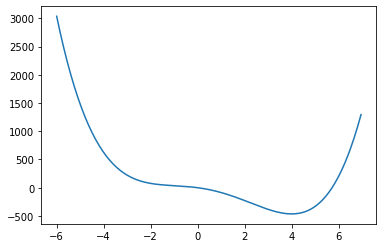

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return 2*x**4 - 5*x**3 - 27*x**2 - 56*x

x = np.arange(-6, 7, 0.05) 
fx = f(x)

plt.plot(x, fx, label="f(x)");

It shouldn't be too hard to find the value of `x` that returns the minimal `y`. In this case, it's 4.

But what if our function, instead of just having one input `x`, was a neural network (very complicated function) with a large number of inputs? Well, its really hard to visualize very complex and bumpy high-dimensional surfaces. 

We could use calculus to help us out, calculating ordered derivatives of the loss function (Jacobian or Hessian matrices) to find critical points that could be minima or maxima. But this quickly becomes computationally expensive, which is prohibitive when one of the main advantages of a neural network is its overparameterization and ability to learn from very large amounts of data (don't try this with KaiTorch).

__Given speed is important, we need a more straightforward approach ... like rolling down a slope.__

Turns out that calculating slopes and travelling in the downward direction generally does a good enough job of getting us to a good enough loss value. 

I don't have a satisfying explanation of why this is the case (does anyone?), especially when you consider the high dimensionality/complexity of actual loss curves. However, a common theme around deep learning seems to be developing a vague intuition of why things might work without really reaching a gratifying answer, but that's part of the magic i guess. 

__Welcome to the party :)__

# Rolling down a slope

Let's quickly implement a `RollDownSlope` slope class that simply takes the gradient and travels in the downwards direction with magnitude `self.lr`.

In [46]:
# kaitorch/optimizers.py

import math
from kaitorch.core import Scalar

__all__ = ['SGD', 'Momentum', 'Nesterov', 'Adagrad', 'RMSprop', 'Adam']

class Optimizer:
    pass

In [6]:
class RollDownSlope(Optimizer):
    def __init__(self, lr):
        self.lr = lr

    def __call__(self, p: Scalar):

        p.data = p.data - (self.lr * p.grad)

    def __repr__(self):
        return f'RollDownSlope(lr={self.lr})'

We'll also write this helper function for visualizing gradient descent, which conveniently acts as a framework to explain the training process of a neural network.

_[note: don't declaring variables like i do here, i'm just trying to save you some scrolling]_

In [9]:
def plot_gradient_descent(starting, f, df_dx, optimizer, l_args, m_args, h_args):

    # x is the current value of our weight
    x_l, x_m, x_h = Scalar(starting), Scalar(starting), Scalar(starting)

    # x_list will keep a history of previous weights
    x_l_list, x_m_list, x_h_list = [x_l.data], [x_m.data], [x_h.data]
    
    # choice of optimizer - this is the meat of this notebook
    optimizer_l, optimizer_m, optimizer_h = optimizer(**l_args), optimizer(**m_args), optimizer(**h_args)

    for i in range(10):

        # calculate the gradient at value x
        x_l.grad, x_m.grad, x_h.grad = df_dx(x_l.data), df_dx(x_m.data), df_dx(x_h.data)

        # update the value of x using optimizer (gradient descent)
        optimizer_l(x_l); optimizer_m(x_m); optimizer_h(x_h)

        # store this for visualization
        x_l_list.append(x_l.data); x_m_list.append(x_m.data); x_h_list.append(x_h.data)

    # calculate the loss value for all x in x_list - this is just to help with visualization
    y_l_list, y_m_list, y_h_list = [f(x) for x in x_l_list], [f(x) for x in x_m_list], [f(x) for x in x_h_list]
    
    # plotting
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)
    fig.suptitle(optimizer.__name__, fontsize=20, fontname='Arial', weight='bold')

    axes[0].plot(x, fx, label='f(x)')
    axes[0].plot(x_l_list, y_l_list, 'o-', label="f'(x)", color='black')
    axes[0].set_title(f'{l_args}', fontname='Arial', size=16)

    axes[1].plot(x, fx, label='f(x)')
    axes[1].plot(x_m_list, y_m_list, 'o-', label="f'(x)", color='black')
    axes[1].set_title(f'{m_args}', fontname='Arial', size=16)

    axes[2].plot(x, fx, label='f(x)')
    axes[2].plot(x_h_list, y_h_list, 'o-', label="f'(x)", color='black')
    axes[2].set_title(f'{h_args}', fontname='Arial', size=16)

    plt.tight_layout()
    plt.show()

__Let's start simple by rolling down a parabolic curve__ using different learning rates, which determines the magnitude of our step size (or how fast we roll).

In [10]:
def f(x):
    return x**2

def df_dx(x):
    return 2*x

x = np.arange(-2, 2, 0.05) 

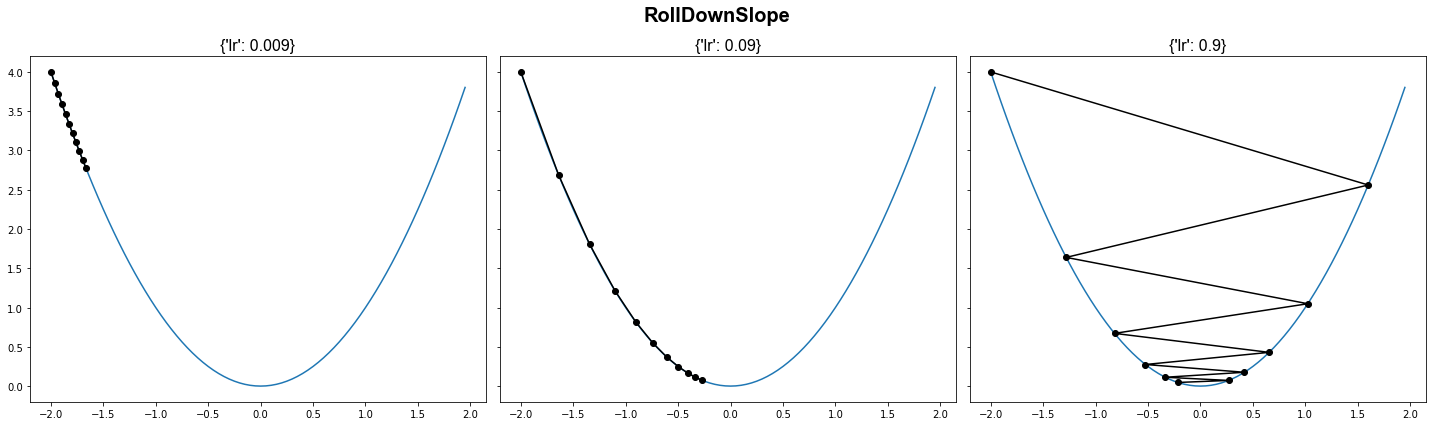

In [11]:
fx = f(x)
dfx_dx = df_dx(x)
plot_gradient_descent(
    starting=-2,
    f=f,
    df_dx=df_dx,
    optimizer=RollDownSlope,
    l_args={'lr': 0.009},
    m_args={'lr': 0.09},
    h_args={'lr': 0.9})

__Intuition takeaways__
 - If we roll too slow, we get to the bottom too slowly but steadily

 - If we roll at the right speed, we get to the bottom quickly and steadily

 - If we roll (bounce?) too fast, we get to the bottom quickly but unsteadily

## Rolling Down a Slope while Slowing Down (aka Learning Rate Decay)

Sometimes, its slow, difficult, or even impossible for a model to converge using a fixed learning rate. 

Learning rate decay is the gradual decrease of learning rate throughout the training process that can help us overcome these scenarios. We start off with a high learning rate, and end with a low learning rate.

Here are some intuitions behind learning rate decay:

__High initial learning rate__
 - By starting with a high learning rate, we can "jump" over bumps and plateaus in the loss function and quickly move towards the ballpark of the minima.

 - Exploration - a high learning rate allows the model to "explore" different areas of the parameter space and find a "promising" regions in the loss function.

__Low final learning rate__
 - By decreasing the learning rate, we can make smaller and more precise adjustments as we get closer to the optimal solution.
 - Exploitation - a lower learning rate allows the model to get to the bottom of a "good enough" local minima once a promising region in the parameter space is found.
 
### Implementing Learning Rate Decay

We'll implement a fairly simple form of learning rate decay called Exponential Decay.

$$ \text{lr}_t = \text{lr}_{\text{initial}} \cdot \text{decay_rate}^t $$

Where $t$ is the number of epochs, in this example we'll just equate one epoch to one iteration. This is fairly easy to implement in the code, we just need to multiply the `learning_rate` by the `decay_rate` after each iteration.

Typically we'll want to use a `decay_rate > 0.95` to prevent learning_rate from decaying too quickly. In this example we'll use 0.7 just to make the effect obvious, but conceptually after 2 epochs we'll have more than halved our learning rate (since $0.7^2=0.49$) which is quite extreme.

In [13]:
class RollDownSlope(Optimizer):

    def __init__(self, lr=0.01, decay_rate=1.0):
        self.lr = lr
        self.decay_rate = decay_rate

    def __call__(self, p: Scalar):

        p.data = p.data - (self.lr * p.grad)

        self.lr *= self.decay_rate

    def __repr__(self):
        return f'RollDownSlope(lr={self.lr})'

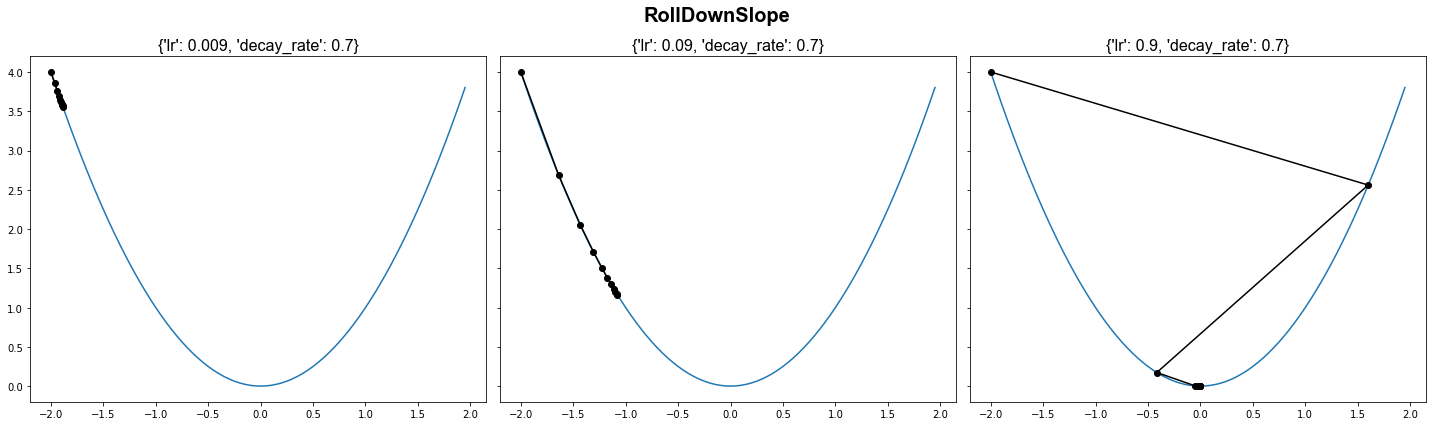

In [14]:
fx = f(x)
dfx_dx = df_dx(x)
plot_gradient_descent(
    starting=-2,
    f=f,
    df_dx=df_dx,
    optimizer=RollDownSlope,
    l_args={'lr': 0.009, 'decay_rate': 0.7},
    m_args={'lr': 0.09, 'decay_rate': 0.7},
    h_args={'lr': 0.9, 'decay_rate': 0.7})

Now we're done with this introductory example, let's go over some commonly used optimizers. Let's also use the function shown at the top of the notebook.

In [15]:
def f(x):
    return 2*x**4 - 5*x**3 - 27*x**2 - 56*x

def df_dx(x):
    return 8*x**3 - 15*x**2 - 54*x - 56

x = np.arange(-6, 7, 0.05) 
fx = f(x)
dfx_dx = df_dx(x)

Let's also quickly adjust our notation, instead of using this notation for gradients:

$$ \frac{\partial L}{\partial W} $$

We will use this upsidedown triangle (nabla) for brevity - it simply represents the vector of partial derivatives. We'll also replace $W$ with $\theta$.
$$ \nabla f(\theta) $$

# Stochastic Gradient Descent

The main idea behind stochastic gradient descent is to approximate the gradient of a function using a single sample. This of course is extremely computationally efficient, as it only requires calculating the forward and backward pass once. However, this could lead to very "unsmooth" convergence, as individual samples aren't necessarily representative.

An adjustment we can make to account for this is to compute the loss value and gradients on a mini-batch, essentially calculating the forward pass of a bunch of samples, calculating one loss value, and then performing one backward pass. Training like this is more likely to lead smooth convergence, as the gradients are averaged over more training samples.

__SGD Formula__

To update a weight $\theta$ using gradient descent:
$$ \theta_{t+1} = \theta_t - \alpha \cdot \nabla f(\theta_t) $$

 - $\alpha$ is the learning rate
 - $\nabla f(\theta_t)$ is the gradient of the loss value with respect to the weight

Basically, we calculate the gradient of weight $\theta$ to find the most "steeply upward facing" direction with respect to the loss function $\nabla f(\theta_t) $ and then travels in the opposite direction by a step size (learning rate) $-\alpha$.

Lets implement the formula above in the `__call__` method of the `SGD` class (aka `RollDownSlope`), and try to apply it on the formula above!

In [16]:
# kaitorch/optimizers.py

class SGD(Optimizer):

    def __init__(self, lr=0.01, decay_rate=1.0):
        self.lr = lr
        self.decay_rate = decay_rate

    def __call__(self, p: Scalar):

        # θ'   = θ      - (α       * ▽f(θ) )
        p.data = p.data - (self.lr * p.grad)
        
        self.lr *= self.decay_rate

    def __repr__(self):
        return f'SGD(lr={self.lr})'

Let's start off with `x=-5` and perform 10 iterations of gradient descent, with `lr=[0.001, 0.003, 0.005]`:

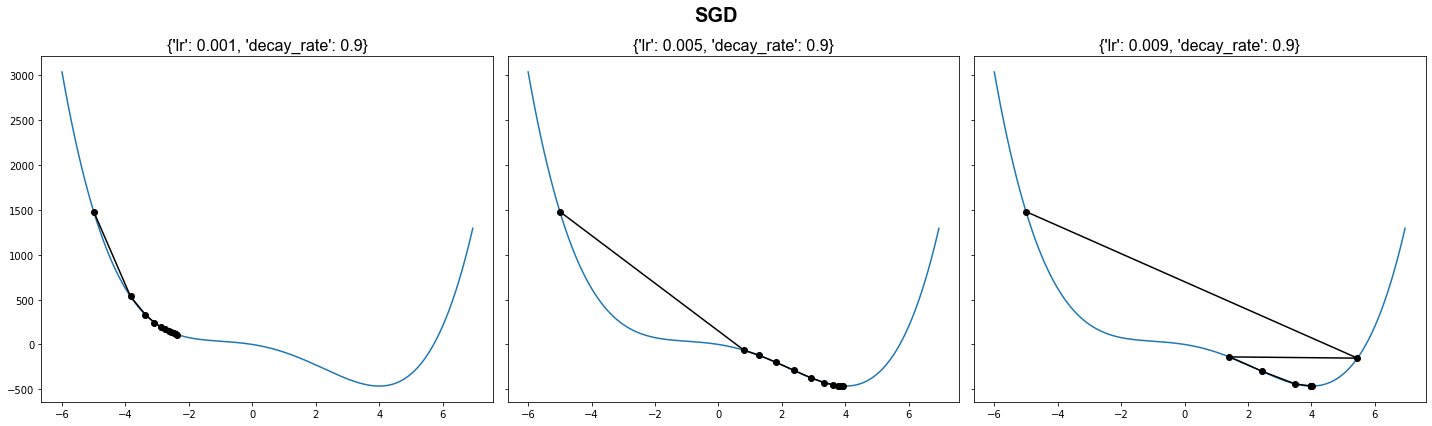

In [17]:
plot_gradient_descent(
    starting=-5,
    f=f,
    df_dx=df_dx,
    optimizer=SGD,
    l_args={'lr': 0.001, 'decay_rate': 0.9},
    m_args={'lr': 0.005, 'decay_rate': 0.9},
    h_args={'lr': 0.009, 'decay_rate': 0.9})

# SGD with Momentum

In SGD with momentum, we introduce an additional `momentum` term to the optimizer. It essentially accumulates past gradients in order to smooth out and accelerate the learning process.

Conceptually, imagine on our way to the minima there is a small hill, and we happen to land on the upwards slope. Under stochastic gradient descent, we would have to travel in the opposite direction of the minima, and we might never make it past that hill.

However, if we accumulate past gradients on our way to the minima, it might give us enough momentum to get past the small hill and continue on our journey towards the minima.

__Momentum Formula__

There are two main formulations of SGD with Momentum you'll find online.

__Version 1__
$$
\begin{equation}
\begin{aligned}
m_{t+1} &= \eta \cdot m_t - (1 - \eta) \cdot \nabla f(\theta_t) \\
\theta_{t+1} &= \theta_{t} - \alpha \cdot m_{t+1} 
\end{aligned}
\end{equation}
$$

 - $\eta$ is the momentum hyperparameter
 - $m$ represents the momentum or velocity at iteration $t$
 - $\alpha$ is the learning rate
 - $ \nabla f(\theta_t)$ is the gradient of the loss value with respect to the weight

In this formulation, we are calculating the exponential weighted average of gradients (controlled by momentum parameter $\eta$) and saving it to our step size or velocity parameter. In every iteration, we are adjusting our weight by subtracting the learning rate multiplied by the step size. This isn't what we'll use in the library, but I'll code it anyways since it will be referenced when we cover `Adam`.

In [18]:
# kaitorch/optimizers.py

class Momentum(Optimizer): # Version 1

    def __init__(self, lr=0.01, momentum=0.9, decay_rate=1.0):
        self.lr = lr
        self.momentum = momentum
        self.decay_rate = decay_rate

    def __call__(self, p: Scalar):

        if not hasattr(p, 'm'):
            p.m = 0.0

        # m'= η             * m   + (1 - η            ) * ▽f(θ)
        p.m = self.momentum * p.m + (1 - self.momentum) * p.grad

        # θ'   = θ      - α       * m'
        p.data = p.data - self.lr * p.m

        self.lr *= self.decay_rate

    def __repr__(self):
        return f'Momentum(lr={self.lr}, momentum={self.momentum})'

__Version 2 (Keras Implementation)__
$$
\begin{equation}
\begin{aligned}
m_{t+1} &= \eta \cdot m_t - \alpha \cdot \nabla f(\theta_t) \\
\theta_{t+1} &= \theta_{t} + m_{t+1} 
\end{aligned}
\end{equation}
$$

This formulation is different to the previous formulation in two ways:
- 1) The learning rate is "baked into" the step size, which is mathematically equivalent
- 2) Multiplication by the $(1-\eta)$ term is not applied to our gradient, which makes these two formulations different.

In this formulation, the momentum term adjusts the weight by adding a fraction (momentum coefficient) of the previous update direction to the current gradient direction. It can be thought of as adding inertia to the update, allowing it to keep moving in the same direction and gain momentum as it approaches the optimum.

This is the version we will use in KaiTorch.

In [19]:
# kaitorch/optimizers.py

class Momentum(Optimizer): # Version 2

    def __init__(self, lr=0.01, momentum=0.9, decay_rate=1.0):
        self.lr = lr
        self.momentum = momentum
        self.decay_rate = decay_rate

    def __call__(self, p: Scalar):

        if not hasattr(p, 'm'):
            p.m = 0.0
            
        # m'= (η             * m  ) - (α       * ▽f(θ) )
        p.m = (self.momentum * p.m) - (self.lr * p.grad)
        
        # θ'   = θ      + m'
        p.data = p.data + p.m

        self.lr *= self.decay_rate

    def __repr__(self):
        return f'Momentum(lr={self.lr}, momentum={self.momentum})'

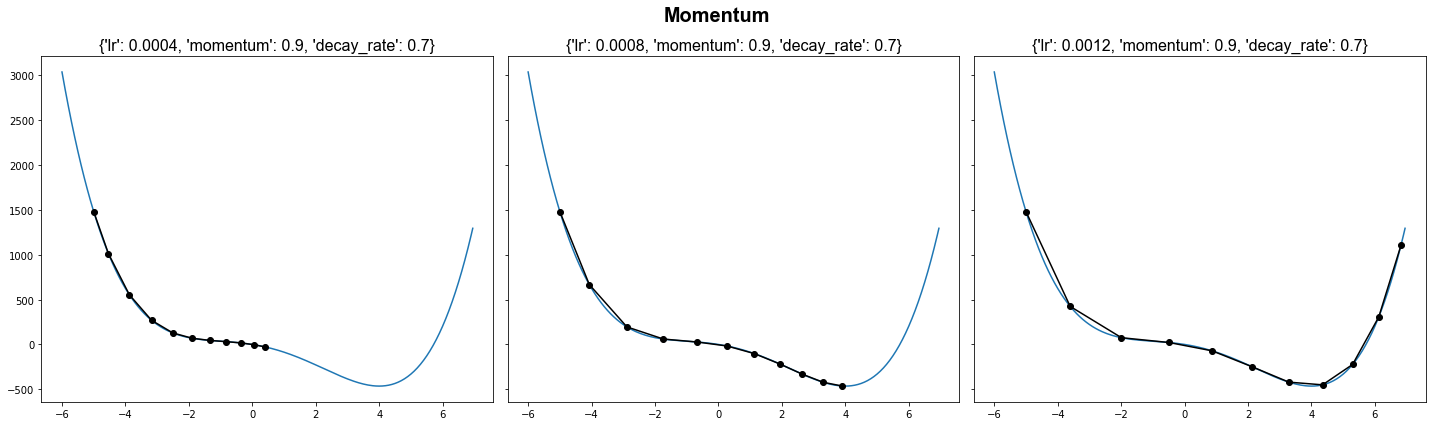

In [20]:
plot_gradient_descent(
    starting=-5,
    f=f,
    df_dx=df_dx,
    optimizer=Momentum,
    l_args={'lr': 0.0004, 'momentum': 0.9, 'decay_rate':0.7},
    m_args={'lr': 0.0008, 'momentum': 0.9, 'decay_rate':0.7},
    h_args={'lr': 0.0012, 'momentum': 0.9, 'decay_rate':0.7})

# SGD with Nesterov Momentum

SGD with Nesterov Momentum, or Nesterov Accelerated Gradient (NAG) is an optimizer that further modifies the previous momentum approach.

With NAG, the gradient is evaluated at a position slightly ahead of the current position in the direction of the momentum. This is an attempt to anticipate the future position when calculating the gradient, taking into account the expected influence of the momentum term on the next iteration.

__An example using non-math words__

Conceptually (and perhaps not entirely analogous but hopefully it'll provide some intuition and amusing imagery) imagine I was rolling down a mountain towards the bottom of the hill (carrying lots of momentum!). To avoid large rocks, it would be wise to adjust my direction of rolling not based on where I am now, but rather where I will be by the time I can switch directions.

I'll notice by the time I change direction, that there's a small change in where I thought I was going to be, versus where I ended up, because I don't know the exact slope of the lower parts of the hill until I roll onto them.

Now, again, I will anticipate where I will roll towards with my momentum, and try to act in advance in accordance to which direction I think will help me avoid rocks and reach the bottom of the hill by the time I can change direction again.

__Nesterov Formula__

$$
\begin{equation}
\begin{aligned}
m_{t+1} &= \eta \cdot m_t - \alpha \cdot \nabla f(\theta_t + \eta \cdot m_t)\\
\theta_{t+1} &= \theta_{t} + m_t
\end{aligned}
\end{equation}
$$

You'll see this is the exact same formula as classical Momentum, except we take the gradient of a weight with the lookahead term added.

Simple enough, but there's one big problem - we don't have the gradient of the "lookahead weight", and computing this additional gradient would be computationally expensive.

### Calculating Look-ahead Gradient
_[note: prepare for a headache because this gave me one]_

There's a pretty ingenious answer to this problem: __instead of tracking $\theta$, we track $\theta + \eta \cdot m_t$__. (_😵‍💫 ? wat ? 😵‍💫_)

__An Attempt at a Simple Explanation:__

- Just as with Momentum, we store a `step` value to track the previous step taken

- The only gradient needed for NAG is for the "lookahead position"

- We want to make weight updates based on the "current position"

- We can get the "current position" (what $\theta$ typically represents) by backtracking `step` from the "lookahead position" (what $\theta$ represents in NAG)

So, if $\theta$ tracks the "lookahead weight", this is how we perform NAG:

- Get the "current position" by calculating `lookahead_position - momentum * step`

- Calculate "lookahead gradient" by calculating $\nabla f(\theta)$ just as we would with any optimizer

- Use the "lookahead gradient" to update the "current position

- Look ahead again! Now in the next iteration we can directly calculate the "lookahead gradient" once more

__Nesterov Formula (Rewritten)__

With $\theta$ redefined to be the lookahead position, we can rewrite like so:

$$
\begin{equation}
\begin{aligned}
m_{t+1} &= \eta \cdot m_t - \alpha \cdot \nabla f(\theta_t)\\
\theta_{t+1} &= \theta_t - (\eta \cdot m_t) + (\eta \cdot m_t - \alpha \cdot \nabla f(\theta_t)) + (\eta \cdot \eta \cdot m_t - \alpha \cdot \nabla f(\theta_t)) \\
&= \theta_t - {}^1(\eta \cdot m_t) + {}^2(\eta \cdot m_t - \alpha \cdot \nabla f(\theta_t)) + {}^3(\eta \cdot m_{t+1}) \\
\end{aligned}
\end{equation}
$$

_[note: the superscripts are labels to reference the steps below, not math symbols]_

Our formulation of a "step" is exactly the same as classical Momentum, with the caveat that $\theta_t$ represents the lookahead position, nothing crazy here.

The $\theta_{t+1}$ term is where it gets interesting. Recalling that we are in the lookahead position, this is how we update our weight.

- 1) __"The Backtrack"__ Return to the non-lookahead position, which is simply the momentum hyperparameter times the previous step taken
- 2) __"The Update"__, apply the classical momentum step to update the weight to the next position.
- 3) __"The Jump (Lookahead)"__, apply another lookahead step.

Notice how the backtrack $- \eta \cdot m_t$ is expressed similarly to the lookahead $+ \eta \cdot m_{t+1}$, it should be obvious how __the lookahead of the current iteration will be cancelled out by the backtrack of the next iteration__.

### KaiTorch Implementation

It turns out step 1 and 2 can be combined, as the positive and negative $\eta \cdot m_t$ terms cancel out. We can reformulate the steps like such:
- __"The Backtrack"__ + __"The Update"__ = __"The Correction"__

__Nesterov Formula (Final Implementation)__

$$
\begin{equation}
\begin{aligned}
m_{t+1} &= \eta \cdot m_t - \alpha \cdot \nabla f(\theta_t)\\
\theta_{t+1} &= \theta_t - (\eta \cdot m_t) + (\eta \cdot m_t - \alpha \cdot \nabla f(\theta_t)) + (\eta \cdot m_{t+1}) \\
&= \theta_t - {}^1(\alpha \cdot \nabla f(\theta_t)) + {}^2(\eta \cdot m_{t+1}) \\
&= \theta_t + (\eta \cdot m_{t+1}) - (\alpha \cdot \nabla f(\theta_t))
\end{aligned}
\end{equation}
$$

- 1) __"The Correction"__, update our weight based on look-ahead gradient
- 2) __"The Jump (Lookahead)"__, apply another lookahead step.

Now our formulation of NAG is in terms that are easily substitutable and can be directly implemented!

### Final Nuance

For completeness, here's one last quick point.

Since we redefined $\theta$ to track "lookahead weight" instead of the "current weight", all of our neural network weights trained with NAG will have this "lookahead step" applied.

To explain why this isn't a problem, recall lookahead weight is expressed as $\theta + \eta \cdot m_t$, so as learning converges and step sizes $m_t$ become smaller, the value converges towards $\theta$. Alternitavely, if learning doesn't converge, you have a much bigger problem to worry about :)

In [21]:
# kaitorch/optimizers.py

class Nesterov(Optimizer):

    def __init__(self, lr=0.01, momentum=0.9, decay_rate=1.0):
        self.lr = lr
        self.momentum = momentum
        self.decay_rate = decay_rate

    def __call__(self, p: Scalar):

        if not hasattr(p, 'm'):
            p.m = 0.0

        # m'= (η             * m  ) - (α       * ▽f(θ) )
        p.m = (self.momentum * p.m) - (self.lr * p.grad) 

        # θ'   = θ      + (η             * m' ) - (α       * ▽f(θ) )
        p.data = p.data + (self.momentum * p.m) - (self.lr * p.grad)

        self.lr *= self.decay_rate

    def __repr__(self):
        return f'Nesterov(lr={self.lr}, Momentum={self.momentum})'

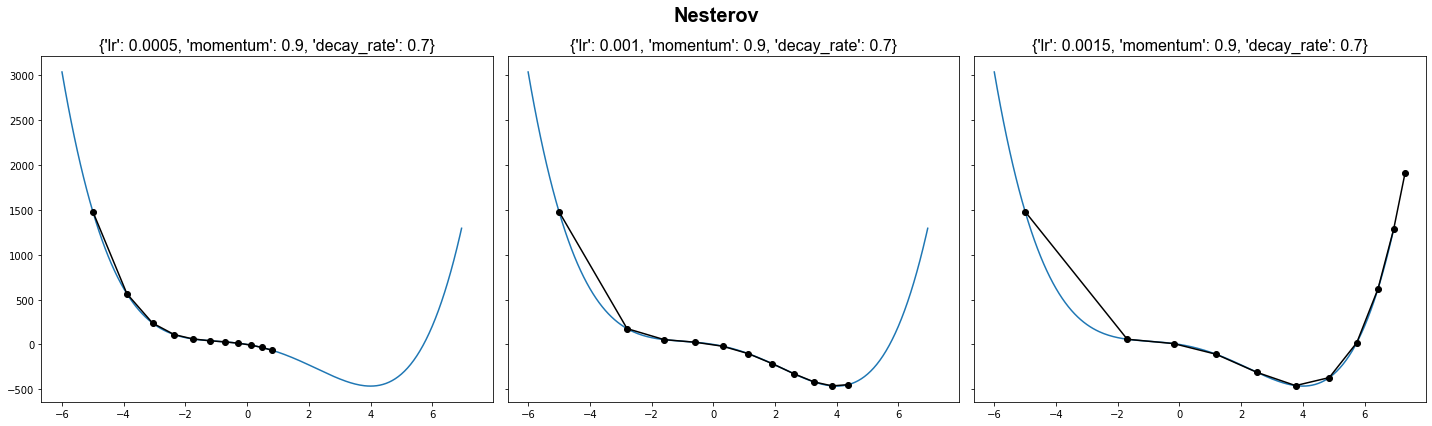

In [22]:
plot_gradient_descent(
    starting=-5,
    f=f,
    df_dx=df_dx,
    optimizer=Nesterov,
    l_args={'lr': 0.0005, 'momentum': 0.9, 'decay_rate':0.7},
    m_args={'lr': 0.0010, 'momentum': 0.9, 'decay_rate':0.7},
    h_args={'lr': 0.0015, 'momentum': 0.9, 'decay_rate':0.7})

# Adagrad

__Adagrad (Adaptive Gradient Algorithm)__ is the first of our adaptive optimizers implemented in KaiTorch.

The key feature of adaptive optimizers are that they use historical values of the gradients to adjust the learning rate for every parameter differently. That is to say, every parameter will effectively have its own learning rate.

Adaptive optimizers do this by tracking/accumulating the previous gradients of each parameter (each optimizer does this differently), introducing an adaptive element unique to each parameter that allows the optimizer to adjust the step-size on a per-parameter basis.

__How Adagrad Works__

1) A cumulative sum of the squared gradients for each parameter are stored in $v$, representing the accumulated magnitude of past gradients, or how much a gradient has been adjusted already.

2) The learning rate for each parameter is scaled by dividing the current gradient by the square root of $v$, which has the effect of decreasing learning rate for frequently updated parameters, and maintaining the learning rate for infrequently updated parameters.

__Adagrad Formula__
$$
\begin{equation}
\begin{aligned}
v_{t+1} &= \sum_{i=1}^t (\nabla f(\theta_t))^2 \\
&= v_t + (\nabla f(\theta_t))^2 \\
\theta_{t+1} &= \theta_t - \alpha \cdot \nabla f(\theta_t) \cdot \frac{1}{\sqrt{v_{t+1} + \epsilon}}
\end{aligned}
\end{equation}
$$

In [23]:
# kaitorch/optimizers.py

class Adagrad(Optimizer):

    def __init__(self, lr=0.01, epsilon=1e-8, decay_rate=1.0):
        self.lr = lr
        self.epsilon = epsilon
        self.decay_rate = decay_rate

    def __call__(self, p: Scalar):

        if not hasattr(p, 'v'):
            p.v = 0.0

        # v'= v   + ▽f(θ)^2
        p.v = p.v + p.grad ** 2

        # θ'   = θ      - α       * ▽f(θ)  / (        √ v'   + ε           )
        p.data = p.data - self.lr * p.grad / (math.sqrt(p.v) + self.epsilon)

        self.lr *= self.decay_rate

    def __repr__(self):
        return f'Adagrad(lr={self.lr})'

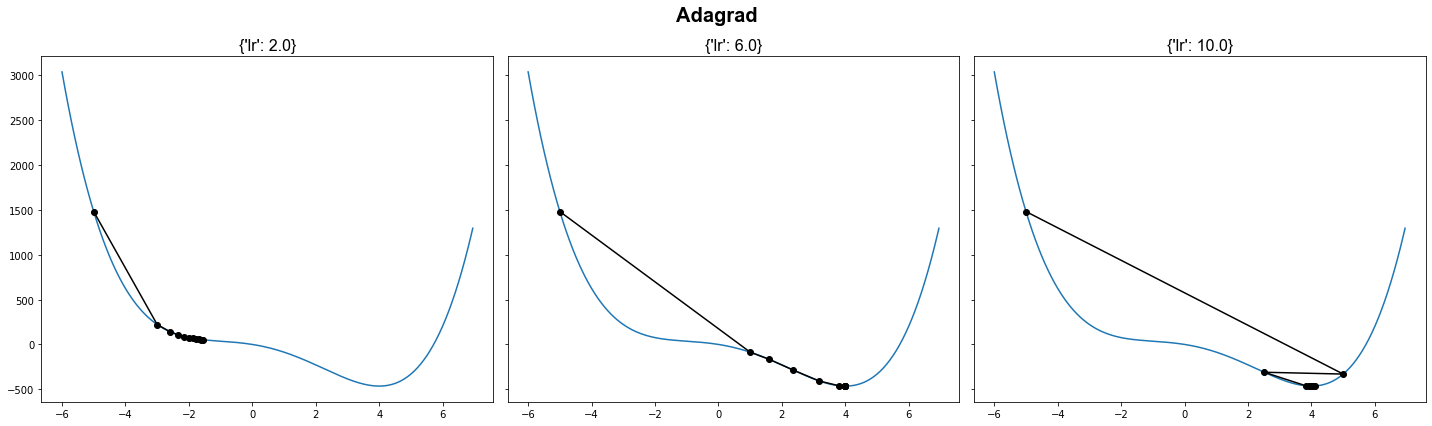

In [26]:
plot_gradient_descent(
    starting=-5,
    f=f,
    df_dx=df_dx,
    optimizer=Adagrad,
    l_args={'lr': 2.0},
    m_args={'lr': 6.0},
    h_args={'lr': 10.0})

# RMSprop

__RMSprop (Root Mean Square Propogation)__ is an extension of Adagrad. It also adapts on a per-parameter basis, and allows parameters with larger values to have a smaller learning rate, and parameters with smaller values to have a larger learning rate.

__How RMSprop Works__

1) Start by calculating the average of the squared gradients of each parameter. This provides information on the magnitude of the gradients.

2) The exponential moving averagem controlled by `rho` (symbol $\rho$) is applied to the square gradients, giving more weight to recent gradients while attenuating past gradients. This gives us a number `v` that captures the trend of the gradient magnitudes.

3) The "adaptive" learning rate for each parameter is scaled by dividing the current gradient by the square root of `v`. This process takes into account the historical gradient magnitudes and has a normalization effect on parameter updates, as parameters with large values will have a smaller learning rate, and parameters with small values will have a larger learning rate.


__RMSprop Formula__
$$
\begin{equation}
\begin{aligned}
v_{t+1} &= \rho \cdot v_t + (1 - \rho) \cdot (\nabla f(\theta_t))^2 \\
\theta_{t+1} &= \theta_t - \alpha \cdot \nabla f(\theta_t) \cdot \frac{1}{\sqrt{v_{t+1} + \epsilon}}
\end{aligned}
\end{equation}
$$
Notice the only thing that changed from Adagrad is how the accumulator stores previous gradients.

In [27]:
# kaitorch/optimizers.py

class RMSprop(Optimizer):

    def __init__(self, lr=0.001, rho=0.9, epsilon=1e-8, decay_rate=1.0):
        self.lr = lr
        self.rho = rho
        self.epsilon = epsilon
        self.decay_rate = decay_rate

    def __call__(self, p: Scalar):

        if not hasattr(p, 'v'):
            p.v = 0.0

        # v'= ρ        * v   + (1 - ρ       ) * ▽f(θ)^2
        p.v = self.rho * p.v + (1 - self.rho) * p.grad ** 2

        # θ'   = θ      - α       * ▽f(θ)  / (        √ v'   + ε)
        p.data = p.data - self.lr * p.grad / (math.sqrt(p.v) + self.epsilon)

        self.lr *= self.decay_rate

    def __repr__(self):
        return f'RMSprop(lr={self.lr}, rho={self.rho})'

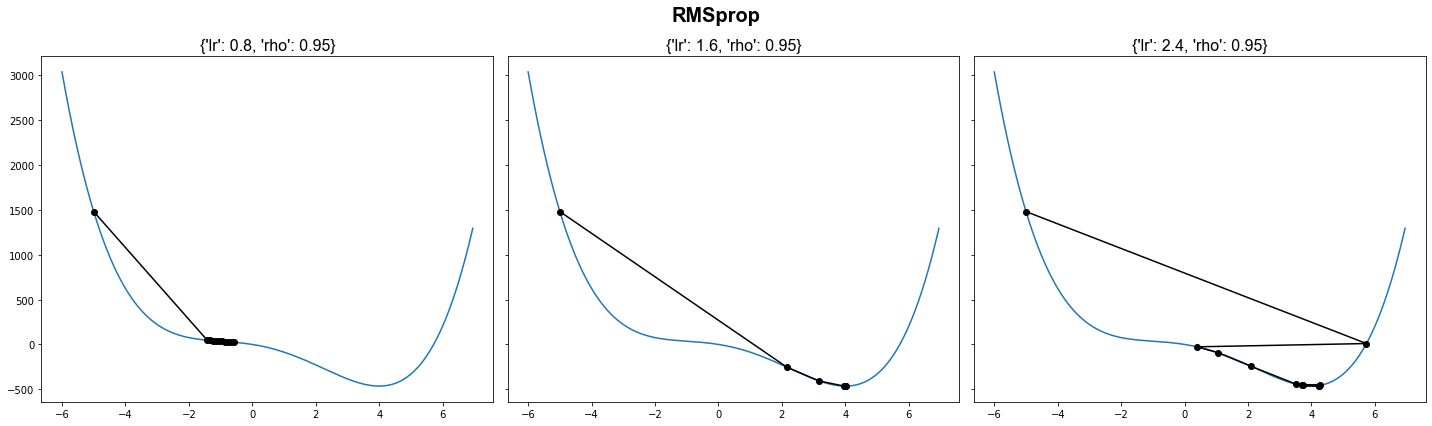

In [28]:
plot_gradient_descent(
    starting=-5,
    f=f,
    df_dx=df_dx,
    optimizer=RMSprop,
    l_args={'lr': 0.8, 'rho': 0.95},
    m_args={'lr': 1.6, 'rho': 0.95},
    h_args={'lr': 2.4, 'rho': 0.95})

# Adam

_This is the optimizer you used on every single classifier on sklearn and got an F1-score of 99.7% with `RandomForestClassifier(n_estimators=500)` on an unrealistically clean dataset in your ML class._

__Adam (Adaptive Moment Estimation)__ is an optimizer that combines the concepts of both momentum and adaptive learning rates.

__How Adam works__

 - 1) Adam tracks two moving average estimates
    - __The first moment (mean) of the gradients.__ This is analogous to how momentum tracks the gradient direction. It is calculated by applying exponential decay (equivalent to EWA in this context) to the gradients, with β1 controlling the decay rate.

   - __The second moment (uncentered variance) of the gradients.__ This is analogous to how adaptive learning rate tracks the gradient magnitude. It is calculated by applying exponential decay to the squared gradients, with β2 controlling the decay rate.

 - 2) To compensate for the initial bias of the estimates, Adam performs a bias correction step. This step involves scaling the first and second moment estimates by a factor that depends on the number of iterations performed.

 - 3) Finally, Adam updates the model parameters by multiplying the current gradient with the adaptive learning rate (second moment estimate divided by the square root of the first moment estimate), and applies the result as a correction to the parameters.

By combining momentum and adaptive learning rates, Adam optimizes the learning process by adjusting the step size for each parameter based on both the direction and the magnitude of the gradients. This enables Adam to converge faster and more efficiently.

### Combining Momentum and RMSprop
The two moving average estimates tracked by Adam are pretty much taken directly from Momentum (v1) and RMSprop. Here's the equations again for your reference. Check out how they're used in the formulation of Adam.

__Momentum__
 - $\eta \rightarrow \beta_1$
$$
\begin{equation}
\begin{aligned}
m_{t+1} &= \beta_1 \cdot m_t - (1 - \eta) \cdot \nabla f(\theta_t) \\
\theta_{t+1} &= \theta_{t} - \alpha \cdot m_{t+1} 
\end{aligned}
\end{equation}
$$

__RMSprop__
 - $\rho \rightarrow \beta_2$
$$
\begin{equation}
\begin{aligned}
v_{t+1} &= \beta_2 \cdot v_t + (1 - \beta_2) \cdot (\nabla f(\theta_t))^2 \\
\theta_{t+1} &= \theta_t - \alpha \cdot \nabla f(\theta_t) \cdot \frac{1}{\sqrt{v_{t+1} + \epsilon}}
\end{aligned}
\end{equation}
$$

__Adam Formula__

$$
\begin{equation}
\begin{aligned}
m_{t+1} &= \beta_1 \cdot m_t + (1 - \beta_1) \cdot \nabla f(\theta_t) \\
v_{t+1} &= \beta_2 \cdot v_t + (1 - \beta_2) \cdot (\nabla f(\theta_t))^2 \\
\hat{m}_{t+1} &= m_{t+1} \cdot \frac{1}{1 - \beta_1} \\ 
\hat{v}_{t+1} &= v_{t+1} \cdot \frac{1}{1 - \beta_2} \\
\theta_{t+1} &= \theta_t - \alpha \cdot \hat{m}_{t+1} \cdot \frac{1}{\sqrt{\hat{v}_{t+1}} + \epsilon} \\
\end{aligned}
\end{equation}
$$

In [29]:
# kaitorch/optimizers.py

class Adam(Optimizer):

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, decay_rate=1.0):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.decay_rate = decay_rate

    def __call__(self, p):

        if not hasattr(p, 'm'):
            p.m = 0.0
        if not hasattr(p, 'v'):
            p.v = 0.0

        # First and Second Moment Estimation

        # m'= β1         * m   + (1 - β1        ) * ▽f(θ)
        p.m = self.beta1 * p.m + (1 - self.beta1) * p.grad
        # v'= β1         * v   + (1 - β2        ) * ▽f(θ)^2
        p.v = self.beta2 * p.v + (1 - self.beta2) * p.grad ** 2

        # Bias Correction

        # m^  = m'  / (1 - β1)
        m_hat = p.m / (1 - self.beta1)
        # v^  = v'  / (1 - β2)
        v_hat = p.v / (1 - self.beta2)
        
        # Parameter Update

        # θ'   = θ      - α       * m^    / (        √ v^   ) + ε           )
        p.data = p.data - self.lr * m_hat / (math.sqrt(v_hat) + self.epsilon)
        
        self.lr *= self.decay_rate

    def __repr__(self):
        return f'Adam(lr={self.lr}, β1={self.beta1}, β2={self.beta2})'

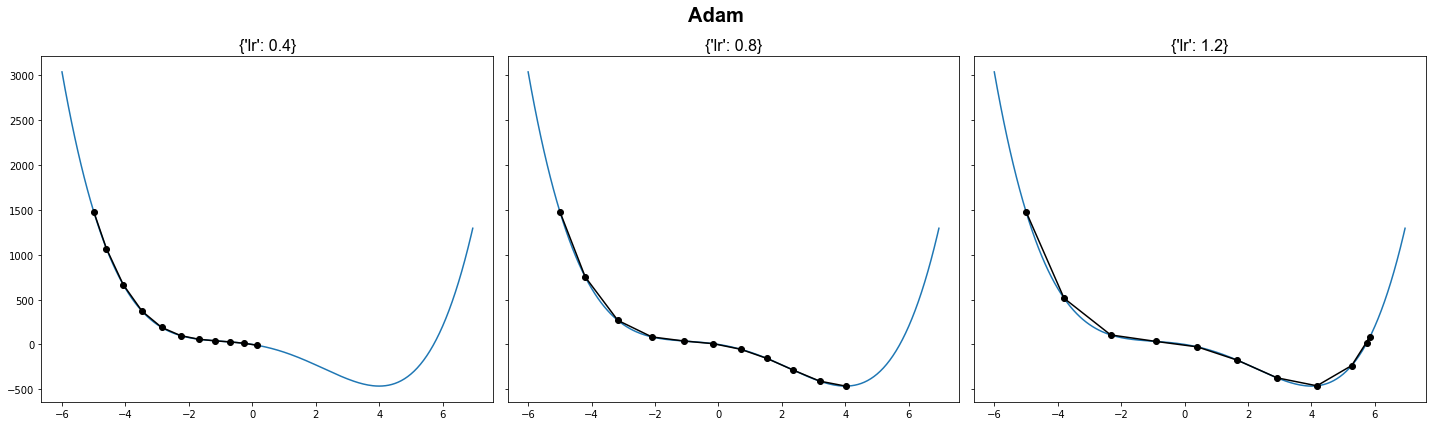

In [30]:
plot_gradient_descent(
    starting=-5,
    f=f,
    df_dx=df_dx,
    optimizer=Adam,
    l_args={'lr': 0.4},
    m_args={'lr': 0.8},
    h_args={'lr': 1.2})

# 2D Visualization

Let's do an example with a more complex function with 2 input variables, visualizing the contour from a "top down" view. This is probably the most dimensions you're going to see for a gradient descent visualization and it comes nowhere near what a neural network loss curve will look like.

I'm not really trying to make or demonstrate any strong claims about any optimizer in this section (even tho adam is goated). The main purpose is to let you observe the qualities of the optimizers for yourself and build intuition around how each one works.

The function we're trying to reach the bottom of is a paraboloid (3d parabola) with some hills and holes (3d bell curves) on it, squiggled by some sines/cosines.

In [31]:
def normal(x0, x1, mu0, mu1, sigma, scale):
    exponent = -((x0 - mu0) ** 2 / (2 * sigma ** 2) + (x1 - mu1) ** 2 / (2 * sigma ** 2))
    dip = scale * (1 / (2 * np.pi * sigma * sigma)) * np.exp(exponent)
    return dip
    
def dnormal_dx0(x0, x1, mu0, mu1, sigma, scale):
    
    exponent = -((x0 - mu0)**2 / (2 * sigma **2) + (x1-mu1)**2 / (2 * sigma **2))
    d_dip = -1 * scale * (1 / (2 * np.pi * sigma**2 * sigma**2)) * (x0 - mu0) * np.exp(exponent)
    return d_dip

def dnormal_dx1(x0, x1, mu0, mu1, sigma, scale):
    
    exponent = -((x0-mu0)**2 / (2 * sigma **2) + (x1-mu1)**2 / (2 * sigma **2))
    d_dip = -1 * scale * (1 / (2 * np.pi * sigma**2 * sigma**2)) * (x1 - mu1) * np.exp(exponent)
    return d_dip

In [33]:
import numpy as np

def fx(x0, x1):

    output = (
        # paraboloid
        80 + x0**2 + x1**2 +
        
        # a hill for us to start on
        normal(x0, x1, mu0=-18.5, mu1=-18, sigma=2, scale=5000) +
        
        # a strong minima to converge on
        normal(x0, x1, mu0=0, mu1=0, sigma=3, scale=-5000) +
        
        # a small dip as a trap
        normal(x0, x1, mu0=-8, mu1=-13, sigma=2, scale=-3000) + 
        
        # a larger dip as a trap
        normal(x0, x1, mu0=16, mu1=0, sigma=3, scale=-10000)

        # squiggles - comment these out for a smoother curve
        + 5*np.cos(x0*2)
        + 5*np.sin(x1*2)
        + 5*np.sin(2*x0*x1)
    )
    return output

def dfx_dx1(x0, x1):
    output = (
        2*x1 +
        dnormal_dx1(x0, x1, mu0=0, mu1=0, sigma=3, scale=-5000) + 
        dnormal_dx1(x0, x1, mu0=-8, mu1=-13, sigma=2, scale=-3000) + 
        dnormal_dx1(x0, x1, mu0=-18.5, mu1=-18, sigma=2, scale=5000) + 
        dnormal_dx1(x0, x1, mu0=16, mu1=0, sigma=3, scale=-10000)

        # d_squiggles
        + 10*x1*np.cos(2*x0*x1) - 10*np.sin(2*x0)
    )
    return output

def dfx_dx0(x0, x1):
    output = (
        2*x0 +
        dnormal_dx0(x0, x1, mu0=0, mu1=0, sigma=3, scale=-5000) + 
        dnormal_dx0(x0, x1, mu0=-8, mu1=-13, sigma=2, scale=-3000) + 
        dnormal_dx0(x0, x1, mu0=-18.5, mu1=-18, sigma=2, scale=5000) + 
        dnormal_dx0(x0, x1, mu0=16, mu1=0, sigma=3, scale=-10000)
        
        # d_squiggles
        + 10*x0*np.cos(2*x0*x1) + 10*np.cos(2*x1)
    )
    return output

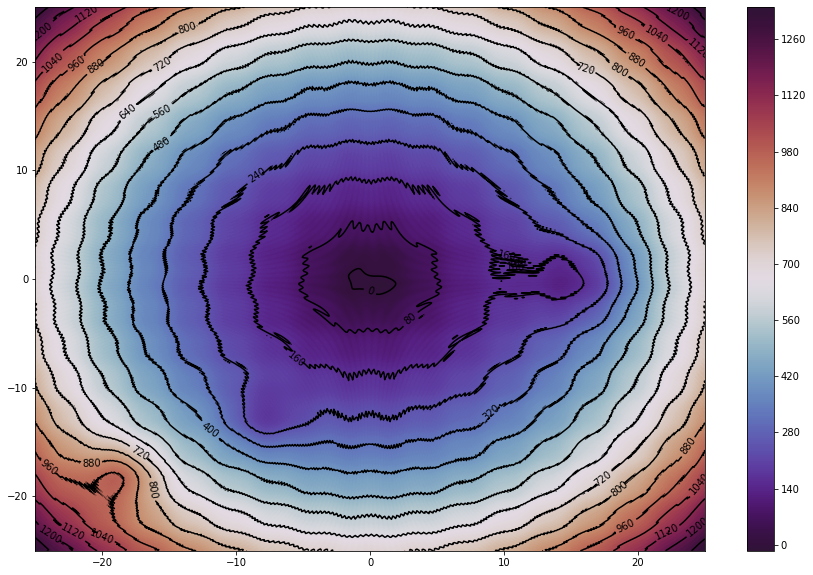

In [34]:
x0_grid = np.linspace(-25, 25, 501)
x1_grid = np.linspace(-25, 25, 501)
x0_grid, x1_grid = np.meshgrid(x0_grid, x1_grid)
y_grid = fx(x0_grid, x1_grid)

plt.figure(figsize=(15, 10))

ctr = plt.contour(x0_grid, x1_grid, y_grid, levels=21, colors='black')
fil = plt.contourf(x0_grid, x1_grid, y_grid, levels=301, cmap='twilight_shifted')

plt.clabel(ctr)
plt.colorbar(fil)
plt.show()

### Feel free to play around

I recommend everyone to play around with the hyperparameters of each optimizer below to see how it affects the descent.

You're also welcome to change the function `fx` to your own if you wish, just remember to update the `dfx_dx0` and `dfx_dx1` functions.

In [42]:
# ----- tweak these ----- #
num_iters = 150

sgd = SGD(lr=0.04, decay_rate=0.97)
momentum = Momentum(lr=0.03, momentum=0.9, decay_rate=0.97)
nesterov = Nesterov(lr=0.01, momentum=0.9, decay_rate=0.97)
adagrad = Adagrad(lr=1.0, decay_rate=1.0)
rmsprop = RMSprop(lr=0.4, rho=0.9, decay_rate=1.0)
adam = Adam(lr=0.4, beta1=0.9, beta2=0.999, decay_rate=1.0)
# ----------------------- #

optimizers = {
    'SGD': sgd,
    'Momentum': momentum,
    'Nesterov': nesterov,
    'Adagrad': adagrad,
    'RMSprop': rmsprop,
    'Adam': adam
}

In [43]:
# calculate the descent

x0_lists = {}
x1_lists = {}

for name, optimizer in optimizers.items():
    x0, x1 = Scalar(-19), Scalar(-19)
    x0_list, x1_list = [x0.data], [x1.data]
    
    for i in range(num_iters):

        x0.grad, x1.grad = dfx_dx0(x0.data, x1.data), dfx_dx1(x0.data, x1.data)
        
        optimizer(x0); optimizer(x1)
        
        x0_list.append(x0.data); x1_list.append(x1.data)
        
    x0_lists[name] = x0_list
    x1_lists[name] = x1_list

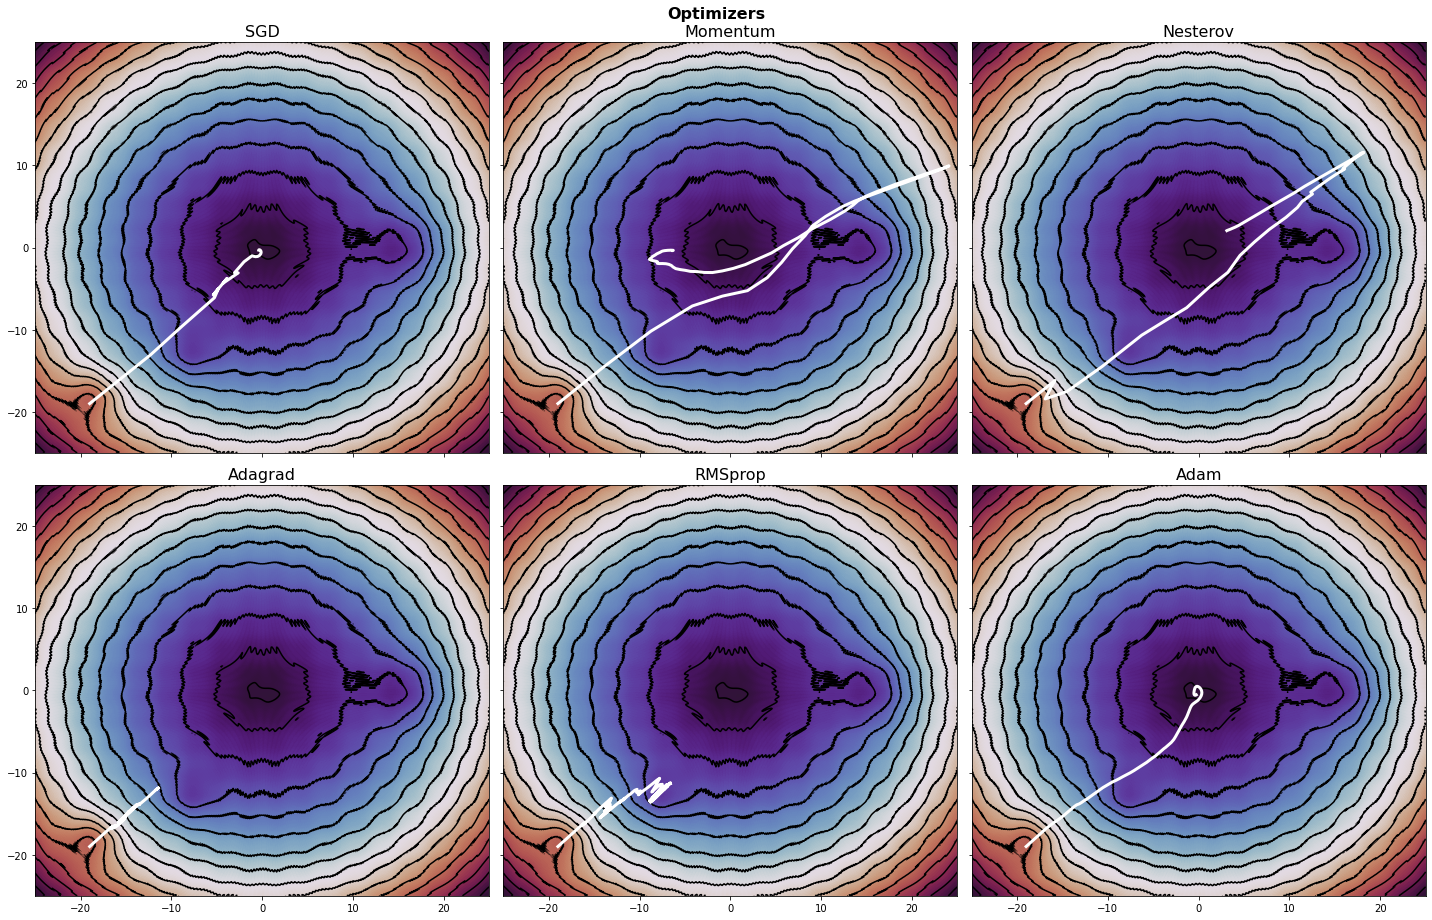

In [44]:
# visualize the descent

x0_grid = np.linspace(-25, 25, 501)
x1_grid = np.linspace(-25, 25, 501)
x0_grid, x1_grid = np.meshgrid(x0_grid, x1_grid)
y_grid = fx(x0_grid, x1_grid)

fig, axes = plt.subplots(2, 3, figsize=(20, 13), sharex=True, sharey=True)
fig.suptitle('Optimizers', fontsize=16, weight='bold')

axes[0, 0].contour(x0_grid, x1_grid, y_grid, levels=16, colors='black')
axes[0, 0].contourf(x0_grid, x1_grid, y_grid, levels=301, cmap='twilight_shifted')
axes[0, 0].plot(x0_lists['SGD'], x1_lists['SGD'], color='white', lw=3)
axes[0, 0].set_title(f'SGD', size=16)

axes[0, 1].contour(x0_grid, x1_grid, y_grid, levels=16, colors='black')
axes[0, 1].contourf(x0_grid, x1_grid, y_grid, levels=301, cmap='twilight_shifted')
axes[0, 1].plot(x0_lists['Momentum'], x1_lists['Momentum'], color='white', lw=3)
axes[0, 1].set_title(f'Momentum', size=16)

axes[0, 2].contour(x0_grid, x1_grid, y_grid, levels=16, colors='black')
axes[0, 2].contourf(x0_grid, x1_grid, y_grid, levels=301, cmap='twilight_shifted')
axes[0, 2].plot(x0_lists['Nesterov'], x1_lists['Nesterov'], color='white', lw=3)
axes[0, 2].set_title(f'Nesterov', size=16)

axes[1, 0].contour(x0_grid, x1_grid, y_grid, levels=16, colors='black')
axes[1, 0].contourf(x0_grid, x1_grid, y_grid, levels=301, cmap='twilight_shifted')
axes[1, 0].plot(x0_lists['Adagrad'], x1_lists['Adagrad'], color='white', lw=3)
axes[1, 0].set_title(f'Adagrad', size=16)

axes[1, 1].contour(x0_grid, x1_grid, y_grid, levels=16, colors='black')
axes[1, 1].contourf(x0_grid, x1_grid, y_grid, levels=301, cmap='twilight_shifted')
axes[1, 1].plot(x0_lists['RMSprop'], x1_lists['RMSprop'], color='white', lw=3)
axes[1, 1].set_title(f'RMSprop', size=16)

axes[1, 2].contour(x0_grid, x1_grid, y_grid, levels=16, colors='black')
axes[1, 2].contourf(x0_grid, x1_grid, y_grid, levels=301, cmap='twilight_shifted')
axes[1, 2].plot(x0_lists['Adam'], x1_lists['Adam'], color='white', lw=3)
axes[1, 2].set_title(f'Adam', size=16)

plt.tight_layout()
plt.show()

# Updating our Sequential class

Now that we have an Optimizer module, we can update some methods in our Sequential class, including the `compile` method mentioned in the previous notebook. 

In [47]:
from kaitorch.models import Sequential

In [48]:
# kaitorch/models.py

def compile(self, optimizer, loss):

    def set_optimizer(optimizer):
        if isinstance(optimizer, str):
            if optimizer in kaitorch.optimizers.__all__:
                self.optimizer = getattr(kaitorch.optimizers, optimizer)()
            else:
                raise Exception(
                    f'[Undefined Optimizer] - Optimizer "{optimizer}" has not been implemented'
                )
        elif isinstance(optimizer, Optimizer):
            self.optimizer = optimizer
        else:
            raise Exception(
                f'[Undefined Optimizer] - Object passed was not an Optimizer'
            )

    def set_loss(loss):
        if isinstance(loss, str):
            if loss in kaitorch.losses.__all__:
                self.loss = getattr(kaitorch.losses, loss)()
            else:
                raise Exception(
                    f'[Undefined Loss Function] - Loss Function "{loss}" has not been implemented'
                )
        else:
            self.loss = loss

    if not self.compiled:
        if optimizer and loss:
            set_optimizer(optimizer)
            set_loss(loss)
            self.compiled = True
        else:
            raise Exception(
                '[Unable to Compile] - Optimizer and Loss Function must be specified'
            )

Sequential.compile = compile

We can now also define a proper `step` method (introduced last notebook aswell) that uses the Optimizers we've built just now.

In [49]:
# kaitorch/models.py

def step(self, **optimizer_params):

    if not self.compiled:
        raise Exception('[Missing Optimizer] - Model has not been compiled')

    for p in self.parameters():
        self.optimizer(p)
        
Sequential.step = step